## Context
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

## Problems
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. 

## Goals
To get an analysis of the fraud transaction and to classify/predict the fraud detection as accurate as possible.

In [1]:
# Import common packages

In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from sklearn import set_config
set_config(print_changed_only=False)

%matplotlib inline

In [3]:
pd.options.display.max_columns = 999

In [130]:
# Read Data
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Checking out the last 5 rows

df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [128]:
# Information of data

df.info()

# the data set has 6.3 million rows and 11 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048815 entries, 0 to 2048814
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int64(2)
memory usage: 109.4 MB


In [7]:
pd.DataFrame(df.columns, columns=['Features'])

,Features
0,step
1,type
2,amount
3,nameOrig
4,oldbalanceOrg
5,newbalanceOrig
6,nameDest
7,oldbalanceDest
8,newbalanceDest
9,isFraud


Features Descriptions

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction, C = Client, M = Merchant

oldbalanceDest - initial balance of recipient before the transaction.

newbalanceDest - new balance of recipient after the transaction.

isFraud - This is the transactions made by the fraudulent agents inside the simulation.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [8]:
# Checking each features description
dfDesc = []

for i in df.columns:
    dfDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        ((df[i].isna().sum())/len(df) *100).round(2),
        df[i].nunique(),
        df[i].drop_duplicates().head(4).values
    ])
print(df.shape[0])
pd.DataFrame(data = dfDesc, columns = ['Features', 'D types', 'Null', 'Null%', 'Unique', 'Unique Value'])

6362620


,Features,D types,Null,Null%,Unique,Unique Value
0,step,int64,0,0.0,743,"[1, 2, 3, 4]"
1,type,object,0,0.0,5,"[PAYMENT, TRANSFER, CASH_OUT, DEBIT]"
2,amount,float64,0,0.0,5316900,"[9839.64, 1864.28, 181.0, 11668.14]"
3,nameOrig,object,0,0.0,6353307,"[C1231006815, C1666544295, C1305486145, C84008..."
4,oldbalanceOrg,float64,0,0.0,1845844,"[170136.0, 21249.0, 181.0, 41554.0]"
5,newbalanceOrig,float64,0,0.0,2682586,"[160296.36, 19384.72, 0.0, 29885.86]"
6,nameDest,object,0,0.0,2722362,"[M1979787155, M2044282225, C553264065, C38997010]"
7,oldbalanceDest,float64,0,0.0,3614697,"[0.0, 21182.0, 41898.0, 10845.0]"
8,newbalanceDest,float64,0,0.0,3555499,"[0.0, 40348.79, 157982.12, 51513.44]"
9,isFraud,int64,0,0.0,2,"[0, 1]"


- No missing values are detected on the dataset.
- NameDest is only half of the nameOrig, explained by the dataset author ***Edgar Lopez Rojas*** on his [Research Paper](http://bth.diva-portal.org/smash/get/diva2:955852/FULLTEXT06.pdf) on section 7, that M stands for merchant which play a passive role during the simulation and the only functions they have is to serve the clients during cash in and cash out transactions.

In [9]:
# looking at statistical description of the data

df.describe().T

# From the first look, we could see on oldbalanceOrig feature has min value of 0.
# If the transaction type is Cash-In or Top up in familiar way to address mobile payment app, then oldbalanceOrg being zero 0 is acceptable, \n
# but if the newbalanceOrg stays 0 then it could be interpreted as missing values
# Other types of transaction type with 0 oldbalanceOrg could be intrepreted as missing values

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


### Handling Missing Values

In [10]:
# Below is to check if there are zero balance on the original old and new balance.

In [475]:
df[(df['type']=='CASH_IN') & (df['oldbalanceOrg']==0) & (df['newbalanceOrig']==0) & (df['amount']!=0)]

# Turns out in transaction type of Cash-In there were no errors/missing values since, after cash-in or top up there were no zero newbalanceOrig

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [476]:
# Checking if the newbalanceDest amount - amount of transaction equals to the amount of oldbalanceDest it means the money is add up correctly.
# And if the money add up correctly but the oldbalanceOrg is zero means it is a missing value

mask1 = df.loc[(df['oldbalanceOrg']==0)&((df['newbalanceDest'] - df['amount']) == df['oldbalanceDest'])&(df['amount']!=0),'amount'].values

# Copyng values of amount feature

In [477]:
df.loc[((df['oldbalanceOrg']==0)&((df['newbalanceDest'] - df['amount']) == df['oldbalanceDest'])&(df['amount']!=0)),'oldbalanceOrg'] = mask1

# Paste the values of amount into oldbalanceOrg

In [478]:
# check to see if its filled

df.iloc[[852]]

# the old balance succesfully change from zero into the amount of transaction

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
852,1240,1,DEBIT,1280.14,C626393072,15159.0,13878.86,C1112414583,11898.0,67762.92,0,0


In [479]:
# Since the data is imbalance, I will Drop zero values oldbalanceOrg which isFraud = 0.

df.drop(df.loc[(df['oldbalanceOrg']==0) & (df['newbalanceOrig']==0) & (df['amount']!=0) & (df['isFraud']==0)].index, inplace=True)

In [480]:
# Checking if its dropped or not

df.loc[(df['oldbalanceOrg']==0) & (df['newbalanceOrig']==0) & (df['amount']!=0) & (df['isFraud']==0)]

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [481]:
# resetting the index
df.reset_index(inplace=True)

In [482]:
# Checking Data after imputing

In [483]:
df.shape

(4863726, 13)

In [20]:
df.head()

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Initial Take on the Dataset
- According to the dataset author ***Edgar Lopez Rojas*** on his [Research Paper](http://bth.diva-portal.org/smash/get/diva2:955852/FULLTEXT06.pdf), The fraudster is trying to take control of the victim accounts and trying to empty the victim balance with 2 methods:
    - By Transfer it to several accounts as mule to temporarily receive the money before its cash out of the system
    - Directly using merchant to cash out the maximum balance allowed.
- Going by those statements, I will focusing on payment type of Transfer and cash out
- By looking on the newbalanceOrg = 0 and the amount is equal to oldbalanceOrg, it is an attempt to emptying balance.
- In order to reduce the number of data to analyze because the lack of computing ability of my device, I will start the analysis only where the amount isFlaggedFraud by the system which is 200,000 above.

## Exploratory Data Analysis


isFraud Distribution amount: 
0    4855513
1       8213
Name: isFraud, dtype: int64


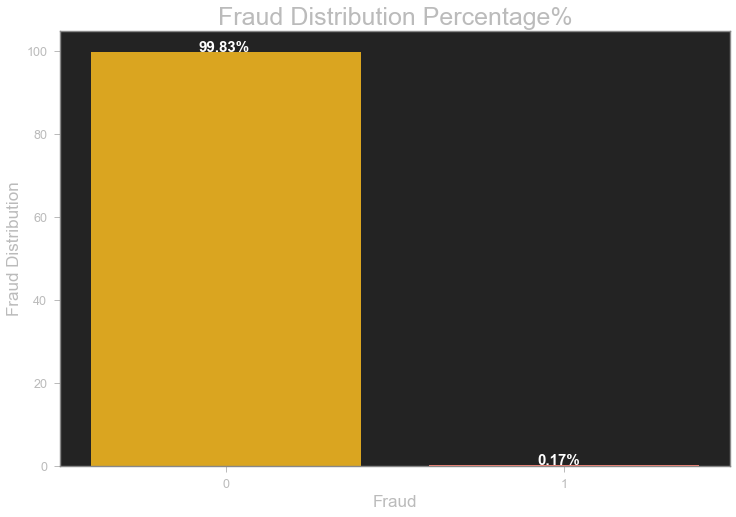

In [21]:
# Checking the distribution of target columns
print(f"isFraud Distribution amount: \n{df['isFraud'].value_counts()}")

Fraud = round(df['isFraud'].value_counts(normalize= True) * 100,2)
x = Fraud.index
y = Fraud.values

plt.figure(figsize=(12,8))  
plt.bar(x, y,color=['goldenrod','salmon']);
plt.xlabel('Fraud',fontdict={'fontsize': 17})
plt.ylabel('Fraud Distribution',fontdict={'fontsize': 17}) 
plt.title('Fraud Distribution Percentage%', fontdict={'fontsize': 25})
for i, v in enumerate(y):   
    plt.text(i-0.08,v+0,f'{v}%',fontweight='bold',color='white',fontsize=15)
plt.xticks([0,1])
plt.show()

# This dataset fraud detection is imbalance, only 0.17% from 4.8 million transactions where tagged/classified as Fraud.
# Next, I will take a further look into isFlaggedFraud feature.

In [22]:
print(f"The Number of transaction with minimum amount of 200,000: {df[df['amount']>200000].amount.count():,}")
print(f"The total data isFlaggedFraud: {df[df['isFlaggedFraud']==1].type.count()}")
print(f"The percentage of data isFlaggedFraud: {(df[df['isFlaggedFraud']==1].type.count()/df[df['amount']>200000].amount.count())*100}")

# From the feature description, we know that isFlaggedFraud is when the system marked an illegal attempt to transfer more than 200.000 in a single transaction. But, we do not know how the system works.
# But we can clearly see that the amount of transaction with more than 200,000 are 1.3 millions data and only 16 transactions/0.001% of them isFlaggedFraud.
# Since it shows an unreliability information, we can drop this feature in our further analysis

The Number of transaction with minimum amount of 200,000: 1,355,511
The total data isFlaggedFraud: 16
The percentage of data isFlaggedFraud: 0.0011803666661502562


Transaction types deemed as Fraud: ['TRANSFER', 'CASH_OUT']


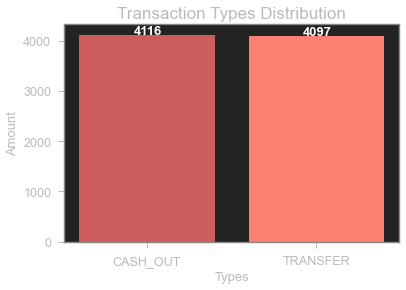

In [23]:
# Checking which Transaction type were detected as fraud

Types = round(df.loc[(df['isFraud']==1),'type'].value_counts(),2)
print(f"Transaction types deemed as Fraud: {[i for i in  df[df['isFraud']==1]['type'].unique()]}")

plt.bar(x=Types.index, height=Types.values, color=['indianred','salmon'])
for i, v in enumerate(Types.values):   
    plt.text(i-0.08,v+3,f'{v}',fontweight='bold',color='white',fontsize=13)
plt.xlabel('Types',fontdict={'fontsize': 13})
plt.ylabel('Amount',fontdict={'fontsize': 13}) 
plt.title('Transaction Types Distribution', fontdict={'fontsize': 17})
plt.show()

# Transaction deemed as fraud were only found in Transfer and Cashout types.
# The total count of Fraud detected on both Types are similar almost 50:50
# As mentioned above on my initial takes, the fraudster modus operandi after taking over the victim account is to Transfer it then cash it out.
# From my point of view, we can drop/delete rows which contain other types of transaction since, because only in these two types of transaction fraud is detected.

- Since the fraudster could possibly make a transaction through merchant and cash out the money, according to the [[Research Paper]](http://bth.diva-portal.org/smash/get/diva2:955852/FULLTEXT06.pdf).  
- Below, Im looking for transaction with name Destination is merchant and isFraud == 1, turns out there were no transaction deemed as fraud when it involved transaction to merchant

In [24]:
df[(df['isFraud']==1) & (df['nameDest'].str.contains('M'))]

# Theres no transaction deemd as fraud when the transaction destination are merchants

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [493]:
# Since the modus operandi of the fraudster transfer the balance into temporary account then cash it out, we want to see if the name destination tagged as Fraud --
# would be in the name origin that Cashout the money.

(df.loc[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER'),'nameDest'].isin(df.loc[(df['isFraud'] == 1) & (df['type'] == 'CASH_OUT'),'nameOrig'])).value_counts()

# It turns out, whenever the NameDestination get a money and tagged as isFraud, it never shows up as the nameOrigin that cashout the money that were tagged as isFraud.

False    4097
Name: nameDest, dtype: int64

In [214]:
# Now we want to see, if there any nameDestination tagged as isFraud and appeared as nameOrigin that Cashout the money and not tagged as Fraud

# df.loc[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER'),'nameDest'].isin(df.loc[(df['isFraud'] == 0) & (df['type'] == 'CASH_OUT'),'nameOrig'])
test = pd.DataFrame(df[(df['isFraud']==1) & (df['type'] == 'TRANSFER')]['nameDest'].isin(df[(df['isFraud']==0) & (df['type'] == 'CASH_OUT')]['nameOrig']))
test[test['nameDest']==True]
a1 = df.loc[[767880,4863662],:]
a2 = df[(df['nameOrig']=='C1714931087') | (df['nameOrig']=='C1023330867') ]
pd.concat([a1,a2]).sort_values('step')

# There are 2 nameOrigin that were tagged as non fraud when Cash out the money but were tagged isFraud when it was a nameDestination.
# However, if we take a look at step (which is a unit of time) only account number C1714931087 that were fit the fraudster modus operandi, the transfer were tagged as isFraud but when Cashout -
# is not detected as fraud.
# Since the evidence is not enough, only 1 account when transfer earlier detected as fraud

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
767880,1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.00,C1714931087,0.00,0.00,1,0
873538,1168398,132,CASH_OUT,29084.28,C1023330867,51999.00,22914.72,C1422447255,0.00,29084.28,0,0
4692287,6149940,546,CASH_OUT,18091.05,C1714931087,197227.00,179135.95,C1339132632,66177.84,84268.89,0,0
4863662,6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.00,C1023330867,0.00,0.00,1,0


In [505]:
# Checking on the amount descriptive stats

Transfer_fraud = df.loc[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER'),['amount']].describe().T
CashOut_fraud = df.loc[(df['isFraud'] == 1) & (df['type'] == 'CASH_OUT'),['amount']].describe().T
fraud_types = pd.concat([Transfer_fraud,CashOut_fraud])
fraud_types

# on both types of transaction, it has similar stats, that the median amount of transaction around 440,000 with q1 amount of 125,000
# 

,count,mean,std,min,25%,50%,75%,max
amount,4097.0,1.480892e+06,2.414890e+06,63.8,128417.96,445705.760,1534985.07,10000000.0
amount,4116.0,1.455103e+06,2.393842e+06,0.0,125464.45,435516.905,1500761.03,10000000.0


In [506]:
# Dropping the other types of transaction since fraud only detected on Transfer and Cash Out

df.drop(df.loc[(df['type']!='CASH_OUT') & (df['type']!='TRANSFER')].index, inplace=True)

In [489]:
# resetting the index and check shape

df.reset_index(inplace=True)
print(df.shape)

(2048815, 13)

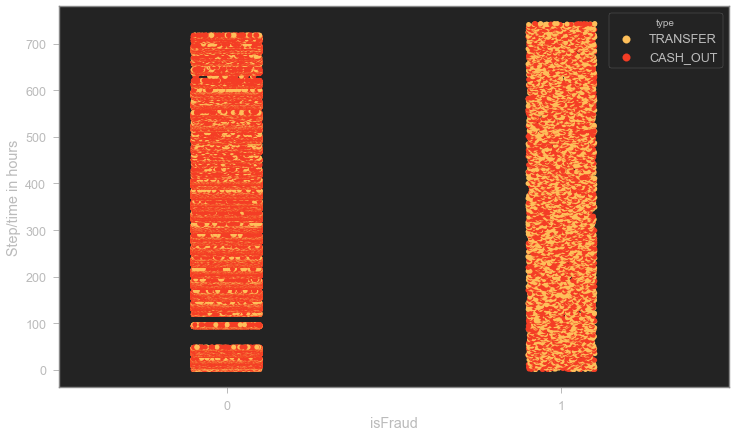

In [494]:
# Checking the step/time in hours

plt.figure(figsize=(12,7))
sns.stripplot(x=df['isFraud'], y=df['step'], hue=df['type'],palette='YlOrRd');
plt.ylabel('Step/time in hours')
plt.show()

# From the plot below, we could see the transaction deemed as fraud were spread evenly from the 1st hour to end.
# While non fraud transactions in below 100 hours seems have a break from any transaction
# the number of Cashout type transaction were more than Transfer transaction on non fraud transaction, while on fraud transaction, the types of these two transactions were spread evenly.

## Conclusion
- From dataset author ***Edgar Lopez Rojas*** on his [Research Paper](http://bth.diva-portal.org/smash/get/diva2:955852/FULLTEXT06.pdf), The fraudster is trying to take control of the victim accounts and trying to empty the victim balance with 2 methods:
    - By Transfer it to several accounts as mule to temporarily receive the money before its cash out of the system
    - Directly using merchant to cash out the maximum balance allowed.
- a fraud transaction were only found in ***Transfer and Cashout*** types. It is proven that the fraudster modus operandi after taking over the victim account is to Transfer it into temporarily account then cash it out.
- While there are possibilities that the fraudster would cash out the victims balance on the merchants, but there were no transactions deeemed as fraud when the destination is a merchant. 
- The nameDest who deemed as Fraud never shows up as nameOrigin in any types of transaction that were also deemed as fraud. Means the fraudster likely to transfer it several times to other temporarily accounts before cash out the balance.
- in 30 days of span, below 100 hours there were moments no transaction were made on non-fraud transactions. While on fraud transactions, there were no moments like that.

### Data Preparation

In [375]:
def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred))
    prec.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))

In [521]:
metric = pd.DataFrame(index = ['Logistic Regression', 'Logistic Regression UnderSampling',
                               'Random Forest Classifier Base US', 'Random Forest Classifier Tuned US',
                               'XGBoost Classifier Base US', 'XGBoost Classifier Tuned US']) 

In [522]:
f1 = []
prec = []
recall = []
acc = []

In [507]:
# # Checking first the transaction types other than Transfer and Cash Out

# print(f"Value Counts isFraud: \n{df.loc[(df['type']!='CASH_OUT') & (df['type']!='TRANSFER'), 'isFraud'].value_counts()}")
# df.loc[(df['type']!='CASH_OUT') & (df['type']!='TRANSFER')].sample(5)

In [508]:
df.head()

,level_0,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,2,2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,3,3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,15,15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,19,19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,24,24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [32]:
df.shape

(2048815, 13)

In [33]:
round(df['isFraud'].value_counts())

0    2040602
1       8213
Name: isFraud, dtype: int64

#### Feature Engineering & Selection

In [34]:
df1= df.copy()

In [35]:
# Drop useless columns

df1.drop(columns=['level_0','index'],inplace=True)

In [36]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [37]:
# Encode the types transaction

df1['Type_encode'] = df1['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

In [38]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Type_encode
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,0
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,0


Import Packages

In [76]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Train Test Split

In [64]:
# drop more un-needed features
df1.drop(columns=['isFlaggedFraud','nameOrig','nameDest','type'],inplace=True)

In [65]:
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Type_encode
0,1,181.00,181.0,0.0,0.0,0.00,1,0
1,1,181.00,181.0,0.0,21182.0,0.00,1,1
2,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1
3,1,215310.30,705.0,0.0,22425.0,0.00,0,0
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0


In [66]:
X = df1.drop(columns=['isFraud'])
y = df1.isFraud

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.2, stratify=y, random_state=21)

In [88]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Type_encode
0,1,181.00,181.0,0.0,0.0,0.00,0
1,1,181.00,181.0,0.0,21182.0,0.00,1
2,1,229133.94,15325.0,0.0,5083.0,51513.44,1
3,1,215310.30,705.0,0.0,22425.0,0.00,0
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [50]:
from sklearn.linear_model import LogisticRegression

In [52]:
# modelLR = LogisticRegression()
# modelLR.fit(X_train, y_train)

### Modelling

In [519]:
ModelLR = LogisticRegression()
ModelLR.fit(X_train,y_train)
y_LR = ModelLR.predict(X_test)
y_train_LR = ModelLR.predict(X_train)

In [523]:
print(classification_report(y_test, y_LR))
evaluationMetrics(y_test,y_LR)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    408120
           1       0.49      0.36      0.41      1643

    accuracy                           1.00    409763
   macro avg       0.74      0.68      0.71    409763
weighted avg       1.00      1.00      1.00    409763



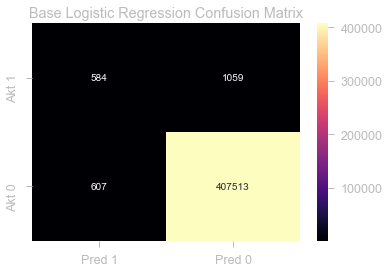

In [87]:
cm_LR = confusion_matrix(y_test, y_LR, labels=[1 , 0])
df_cm_LR = pd.DataFrame(data=cm_LR,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_LR, annot=True, fmt='d',cmap='magma');
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Model Will Focusing on Recall from isFraud 1
We want to avoid Error on False Negative ==> Actual Fraud but detected/predicted as Non-Fraud

## Optimized Model

### Under Sampling
Since the data is way too many for my computer to handle, I will use Undersampling technique.

In [43]:
from sklearn.utils import resample

In [67]:
non_fraud = df1[df1['isFraud'] == 0] 
fraud = df1[df1['isFraud'] == 1] 

In [68]:
non_fraud_undersample = resample(non_fraud,
                                replace=False,
                                n_samples = len(fraud),
                                random_state = 21)

In [69]:
df_UnderSample = pd.concat([non_fraud_undersample, fraud])

In [70]:
df_UnderSample['isFraud'].value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

In [71]:
X_train_US = df_UnderSample.drop(columns='isFraud')
y_train_US = df_UnderSample['isFraud']

In [509]:
X_train_US.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Type_encode
1900906,403,214573.89,14622.00,0.00,1710781.05,1925354.94,1
831759,209,64637.44,64637.44,0.00,5134244.25,5198881.69,0
152596,20,99244.55,7919.00,0.00,13843900.16,13943144.71,1
403792,137,179641.27,179641.27,0.00,2721760.97,2901402.24,1
1618837,354,13138.74,300389.00,287250.26,75247.48,88386.22,1


In [90]:
baseLR = LogisticRegression()
baseLR.fit(X_train_US,y_train_US)
y_base_LR = baseLR.predict(X_test)

In [524]:
print(classification_report(y_test, y_base_LR))
evaluationMetrics(y_test,y_base_LR)

              precision    recall  f1-score   support

           0       1.00      0.78      0.88    408120
           1       0.02      0.89      0.03      1643

    accuracy                           0.78    409763
   macro avg       0.51      0.84      0.46    409763
weighted avg       1.00      0.78      0.88    409763



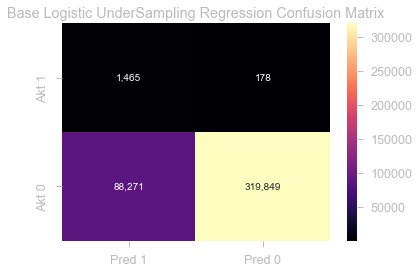

In [225]:
cm_base_LR = confusion_matrix(y_test, y_base_LR, labels=[1 , 0])
df_cm_base_LR = pd.DataFrame(data=cm_base_LR,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_base_LR, annot=True, fmt=',d',cmap='magma');
plt.title('Base Logistic UnderSampling Regression Confusion Matrix')
plt.show()

# with undersampling technique we can see the recall score already much better.

### Scalling
Because the are big difference of scale on step and amount or balance. I will try the scalling method to rescale it for Logistic Regression

In [215]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [513]:
MM = MinMaxScaler()
X_train_scaled = std.fit_transform(X_train_US)
X_test_scaled = std.fit_transform(X_test)

In [514]:
baseLR_scaled= LogisticRegression()
baseLR_scaled.fit(X_train_scaled,y_train_US)
y_base_LR_scaled = baseLR_scaled.predict(X_test_scaled)

In [517]:
print(classification_report(y_test, y_base_LR_scaled))

# after using scale the

              precision    recall  f1-score   support

           0       1.00      0.37      0.54    408120
           1       0.01      0.98      0.01      1643

    accuracy                           0.37    409763
   macro avg       0.50      0.67      0.27    409763
weighted avg       1.00      0.37      0.54    409763



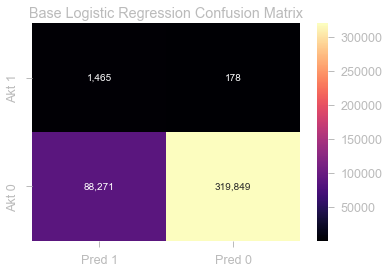

In [516]:
cm_base_LR_scaled = confusion_matrix(y_test, y_base_LR_scaled, labels=[1 , 0])
df_cm_base_LR_scaled = pd.DataFrame(data=cm_base_LR_scaled,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_base_LR, annot=True, fmt=',d',cmap='magma');
plt.title('Base Logistic Regression Confusion Matrix')
plt.show()

#### Random Forest Classifier

In [353]:
modelRF = RandomForestClassifier()
modelRF.fit(X_train_US,y_train_US)
y_RF = modelRF.predict(X_test)

In [525]:
print(classification_report(y_test, y_RF))
evaluationMetrics(y_test,y_RF)
print(f"Train Score: {modelRF.score(X_train_US, y_train_US)}\nTest Score: {modelRF.score(X_test, y_test)}")

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    408120
           1       0.11      1.00      0.20      1643

    accuracy                           0.97    409763
   macro avg       0.56      0.98      0.59    409763
weighted avg       1.00      0.97      0.98    409763

Train Score: 1.0
Test Score: 0.9682352969887471


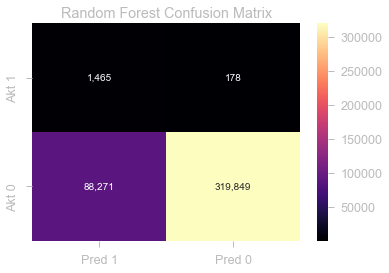

In [118]:
cm_RF = confusion_matrix(y_test, y_RF, labels=[1 , 0])
df_cm_RF = pd.DataFrame(data=cm_RF,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_base_LR, annot=True, fmt=',d',cmap='magma');
plt.title('Random Forest Confusion Matrix')
plt.show()

### XGBoost Classifier

In [343]:
modelXGB = XGBClassifier()
modelXGB.fit(X_train_US,y_train_US)
y_XGB = modelXGB.predict(X_test)

In [526]:
print(classification_report(y_test, y_XGB))
evaluationMetrics(y_test,y_XGB)
print(f"Train Score: {modelXGB.score(X_train_US, y_train_US)}\nTest Score: {modelXGB.score(X_test, y_test)}")

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    408120
           1       0.12      0.98      0.21      1643

    accuracy                           0.97    409763
   macro avg       0.56      0.98      0.60    409763
weighted avg       1.00      0.97      0.98    409763

Train Score: 0.9865457201996835
Test Score: 0.9711540573453435


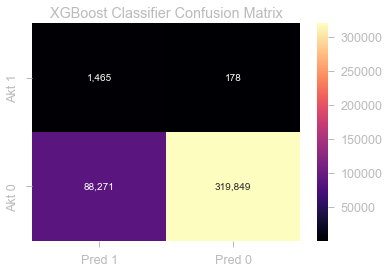

In [126]:
cm_XGB = confusion_matrix(y_test, y_XGB, labels=[1 , 0])
df_cm_XGB = pd.DataFrame(data=cm_XGB,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_base_LR, annot=True, fmt=',d',cmap='magma');
plt.title('XGBoost Classifier Confusion Matrix')
plt.show()

### Hyper Parameter Tuning

In [242]:
from sklearn.pipeline import Pipeline

Random Forest Hyper Parameter Tuning

In [227]:
RF_tuned = RandomForestClassifier()
param_RF = {"n_estimators" : [100,500],
          "max_depth" : [1,5,7],
          "min_samples_split" : [10,8],
          "min_samples_leaf" : [2,4,5,3],
          "max_features" : ['auto',.75,.8]}

In [236]:
model_RF_Tuned = GridSearchCV(estimator=RF_tuned, param_grid=param_RF,cv=5, n_jobs=-1, verbose=1, scoring='recall')
model_RF_Tuned.fit(X_train_US, y_train_US)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5],
                         'max_features': ['auto', 0.75, 0.8],
                         'min_samples_leaf': [2, 4, 5, 3],
                         'min_samples_split': [10, 8],
                         'n_estimators': [100, 500]},
             scoring='recall', verbose=1)

In [237]:
model_RF_Tuned.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 500}

In [238]:
y_tuned_RF = model_RF_Tuned.predict(X_test)

In [527]:
print(classification_report(y_test, y_tuned_RF))
evaluationMetrics(y_test,y_tuned_RF)
print(f"Train Score: {model_RF_Tuned.score(X_train_US, y_train_US)}\nTest Score: {model_RF_Tuned.score(X_test, y_test)}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    408120
           1       0.13      0.86      0.23      1643

    accuracy                           0.98    409763
   macro avg       0.57      0.92      0.61    409763
weighted avg       1.00      0.98      0.99    409763

Train Score: 0.860586874467308
Test Score: 0.8600121728545344


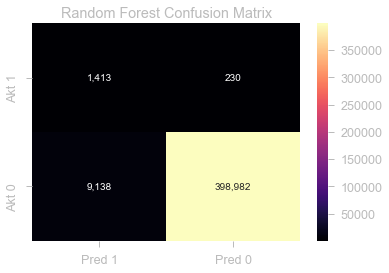

In [240]:
cm_RF_tuned = confusion_matrix(y_test, y_tuned_RF, labels=[1 , 0])
df_cm_RF_tuned = pd.DataFrame(data=cm_RF_tuned,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_RF_tuned, annot=True, fmt=',d',cmap='magma');
plt.title('Random Forest Confusion Matrix')
plt.show()

XGB Hyper Parameter Tuning

In [313]:
modelXGB = XGBClassifier()

In [366]:
param_XGB ={'max_depth': [1,7,1.5,6] ,
             'learning_rate': [.300000012,0.500000012] , 
             'n_estimators': [100,150,500], 
             'gamma': [0,2,.5,1], 
             'colsample_bytree': [1,.6],
             'subsample': [1,.6], 
             'reg_alpha': [0,1,.5],
             'reg_lambda': [1,.5]}

In [367]:
model_XGB_tuned = RandomizedSearchCV(modelXGB, param_distributions=param_XGB, n_jobs=-1, verbose=1, scoring='recall')

In [368]:
XGB_Tuned = model_XGB_tuned.fit(X_train_US, y_train_US)
# XGB_Tuned = pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.8s finished


In [369]:
y_tuned_XGB = XGB_Tuned.predict(X_test)
XGB_Tuned.best_params_

{'subsample': 0.6,
 'reg_lambda': 1,
 'reg_alpha': 0.5,
 'n_estimators': 500,
 'max_depth': 6,
 'learning_rate': 0.500000012,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [528]:
print(classification_report(y_test, y_tuned_XGB))
evaluationMetrics(y_test,y_tuned_XGB)
print(f"Train Score: {XGB_Tuned.score(X_train_US, y_train_US)}\nTest Score: {XGB_Tuned.score(X_test, y_test)}")

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    408120
           1       0.10      1.00      0.17      1643

    accuracy                           0.96    409763
   macro avg       0.55      0.98      0.58    409763
weighted avg       1.00      0.96      0.98    409763

Train Score: 0.9995129672470474
Test Score: 0.9987827145465612


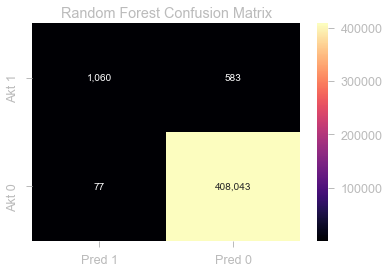

In [267]:
cm_XGB_tuned = confusion_matrix(y_test, y_tuned_XGB, labels=[1 , 0])
df_cm_XGB_tuned = pd.DataFrame(data=cm_XGB_tuned,index=["Akt 1" ,"Akt 0"], columns=["Pred 1", "Pred 0"])
sns.heatmap(df_cm_XGB_tuned, annot=True, fmt=',d',cmap='magma');
plt.title('Random Forest Confusion Matrix')
plt.show()

## Evaluation

In [529]:
metric['F1-Score'] = f1
metric['Recall'] = recall
metric['Precision'] = prec
metric['Accuracy'] = acc

In [530]:
metric.sort_index()

,F1-Score,Recall,Precision,Accuracy
Logistic Regression,0.412138,0.355447,0.490344,0.995934
Logistic Regression UnderSampling,0.032064,0.891662,0.016326,0.784146
Random Forest Classifier Base US,0.201570,1.000000,0.112081,0.968235
Random Forest Classifier Tuned US,0.214096,0.979915,0.120176,0.971154
XGBoost Classifier Base US,0.231753,0.860012,0.133921,0.977138
XGBoost Classifier Tuned US,0.174222,0.998783,0.095435,0.962037


### Comparing y_test Predict vs Actual

In [436]:
X_test.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Type_encode
1314786,302,249175.07,951.00,0.0,1057215.44,1306390.51,1
1965402,526,115872.44,59942.00,0.0,379079.68,494952.13,1
1646492,356,334390.29,6213.00,0.0,46478.16,380868.44,1
1001582,237,244157.26,154184.00,0.0,332574.67,576731.93,1
955974,233,115772.62,115772.62,0.0,2024428.58,2140201.20,1


In [416]:
df_baru = pd.DataFrame(X_test, columns=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','Type_encode'])

In [417]:
df_baru["y_true"] = y_test.values
df_baru["y_pred"] = y_tuned_XGB

In [441]:
df_baru.shape

(409763, 9)

In [424]:
Errorfound = df_baru[(df_baru['y_pred']==0) & (df_baru['y_true']==1)]
Errorfound

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Type_encode,y_true,y_pred
892818,226,195708.55,195708.55,0.0,5705050.51,5900759.07,1,1,0
1752433,379,99458.21,99458.21,0.0,425060.84,524519.05,1,1,0


In [456]:
Error_FP = df_baru[(df_baru['y_pred']==1) & (df_baru['y_true']==0)]
Error_FP[['amount']].describe().T

,count,mean,std,min,25%,50%,75%,max
amount,15554.0,190082.374977,254877.351328,4.99,47260.78,125881.74,256499.64,10000000.0


In [462]:
print('x'*10,'Results of Machine Predicted Non Fraud But Actual Fraud','x'*10)
print(f"Total Errors Found: {Errorfound.step.count()}\nTotal Amount Loss: {Errorfound.amount.sum():,}")
print(f"Total Transactions Amount: {df_baru.amount.sum():,}\nTotal Data: {len(df_baru.step):,}")
coba = round((Errorfound.amount.sum()/df_baru.amount.sum())*100,4)
print('Amount Loss percentage',coba,'%')
print(f"Error Percentage: {round((2/409763)*100,5)}%")

xxxxxxxxxx Results of Machine Predicted Non Fraud But Actual Fraud xxxxxxxxxx
Total Errors Found: 2
Total Amount Loss: 295,166.76
Total Transactions Amount: 124,733,242,234.00002
Total Data: 409,763
Amount Loss percentage 0.0002 %
Error Percentage: 0.00049%


In [463]:
print(f"Error Percentage of Machine predict fraud but actual Non Fraud: {round(Error_FP.step.count()/len(df_baru)*100,2)}%")

Error Percentage of Machine predict fraud but actual Non Fraud: 3.8%


# CONCLUSION
- With using XGB Hyper Paratemeter Tuning Algorithm, the model succeeded on lowering the errors on predicting a fraud as non fraud => FN, Just as our initial goal.
- With only 2 errors from total data of 409,763, approximately 0.000498% error percentage.
- While the model indeed has more errors on predicting a fraud but actual is non Fraud with 3.8%, the model still manage to have a median amount of 125,000. Which is good because a transaction with more than 100,000 in single transaction is quite big amount
- Note that dataset is simulates PaySim a mobile money transactions, which is when FP is high or machine predict fraud but actual non fraud the company loses **0 amount**.
- That is way this project focusing the model on lowering errors on predicting a non fraud but actual is fraud.
